In [1]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

# Now you can use absolute imports
from src.utils.data_processing import load_data, preprocess_data
from src.utils.defaults import DEFAULTS, DIAMETER_DICT, THICKNESS_DICT, FLOWRATE_DICT, TEMPERATURE_DICT

In [2]:
import pandas as pd
from pathlib import Path

data_path = Path.cwd().parent / 'data' / 'multi_pressure' / 'S4R3.xlsx'
exp_data = pd.read_excel(data_path)

In [3]:
exp = 'S4R3'
processed_data = preprocess_data(
    data=exp_data, 
    temperature= TEMPERATURE_DICT[exp],
    thickness= THICKNESS_DICT[exp], 
    flowrate= FLOWRATE_DICT[exp],
    diameter= DIAMETER_DICT[exp])

processed_data = processed_data[['time', 'flux', 'yCO2_bl', 'pressure']]

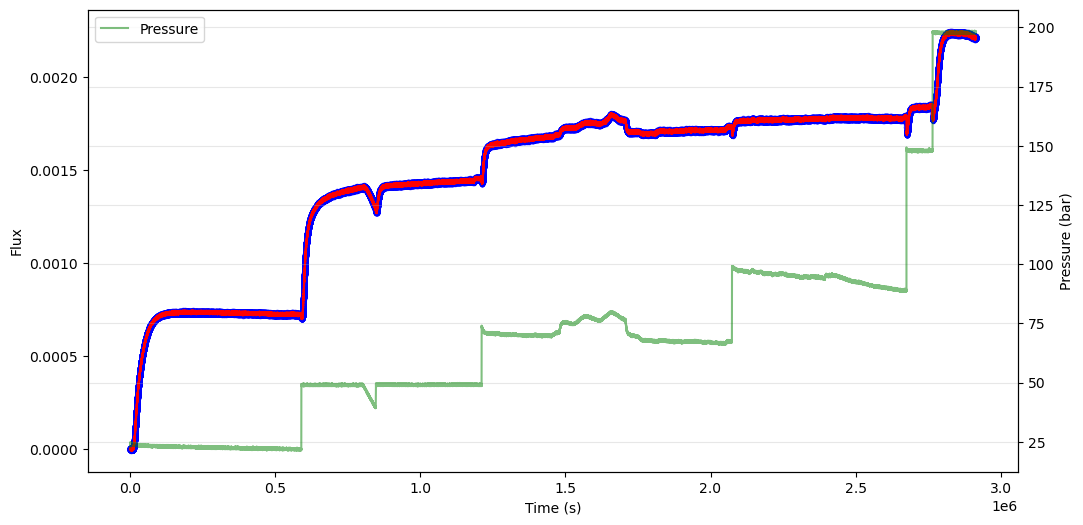

In [30]:
# Function to identify steady-state region
def identify_steady_state_region(df, column='flux', eps=0.001, window=100):
    slopes = df[column].diff() / df["time"].diff()
    df["slope_change_mean"] = slopes.diff().abs().rolling(window=window).mean()
    df["slope_change_min"] = slopes.diff().abs().rolling(window=window).min()
    df["slope_change_max"] = slopes.diff().abs().rolling(window=window).max()

    # find steady state region
    df["steady_state"] = df["slope_change_mean"] < eps
    # df["pct_change_mean"] = (
    #     (df[column].diff() / df["time"].diff())
    #     .pct_change()
    #     .abs()
    #     # .rolling(window=window)
    #     # .mean()
    # )
    # df["pct_change_min"] = (
    #     (df[column].diff() / df["time"].diff())
    #     .pct_change()
    #     .abs()
    #     .rolling(window=window)
    #     .min()
    # )
    # df["pct_change_max"] = (
    #     (df[column].diff() / df["time"].diff())
    #     .pct_change()
    #     .abs()
    #     .rolling(window=window)
    #     .max()
    # )
    # df["pct_change_median"] = (
    #     (df[column].diff() / df["time"].diff())
    #     .pct_change()
    #     .abs()
    #     .rolling(window=window)
    #     .median()
    # )
    return df

# Usage
processed_data_copied = processed_data.copy()
processed_data_copied = identify_steady_state_region(processed_data_copied, column='flux', eps=0.000008, window=100)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(processed_data_copied['time'], processed_data_copied['flux'], 'b.', alpha=0.7, label='Flux')

# Highlight steady state regions
steady_state_data = processed_data_copied[processed_data_copied['steady_state'] == True]
# plt.fill_between(steady_state_data['time'], [0], steady_state_data['flux'], alpha=0.3, color='red', label='Steady State')
plt.plot(steady_state_data['time'], steady_state_data['flux'], 'r-', alpha=1.0, label='Steady State')
plt.ylabel('Flux')
plt.xlabel('Time (s)')

plt.twinx()
plt.plot(processed_data_copied['time'], processed_data_copied['pressure'], 'g-', alpha=0.5, label='Pressure')
plt.ylabel('Pressure (bar)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [38]:
# If pressure is not specified, use average pressure from data within time_range
steady_state_regions = {
    "S4R3": [
        # First, 25 bar
        {
            "notes": "First steady state",
            "time_range": [170e3, 220e3],
            # "pressure": "Unknown",  # Average will be calculated
            # "flux": "Unknown",  # Average  will be calculated
        },
        # Second, 50 bar
        {
            "notes": "Second steady state",
            "time_range": [880e3, 900e3],
            # "pressure": "Unknown",  # Average will be calculated
            # "flux": "Unknown",  # Average  will be calculated
        },
        # Third, 75 bar
        {
            "notes": "Third steady state",
            "time_range": [1.85e6, 1.9e6],
            # "pressure": "Unknown",  # Average will be calculated
            # "flux": "Unknown",  # Average  will be calculated
        },
        # Fourth, 100 bar
        {
            "notes": "Fourth steady state",
            "time_range": [2.1e6, 2.15e6],
            # "pressure": "Unknown",  # Average will be calculated
            # "flux": "Unknown",  # Average  will be calculated
        },
        # Fifth, 150 bar
        {
            "notes": "Fifth steady state",
            "time_range": [2.7e6, 2.75e6],
            # "pressure": "Unknown",  # Average will be calculated
            # "flux": "Unknown",  # Average  will be calculated
        },
        # Sixth, 200 bar
        {
            "notes": "Sixth steady state",
            "time_range": [2.82e6, 2.85e6],
            "pressure": "Unknown",  # Average will be calculated
            "flux": "Unknown",  # Average  will be calculated
        }
    ]
}

# Calculate missing pressures from data
def calculate_missing_pressures_fluxes(regions_dict, df, experiment_name):
    """Calculate average pressure for regions where pressure is not specified"""
    if experiment_name in regions_dict:
        for region in regions_dict[experiment_name]:
            # If pressure is not specified or "Unknown", calculate it from the data
            if 'pressure' not in region or region['pressure'] == "Unknown":
                time_start, time_end = region['time_range']
                # Filter data within time range
                mask = (df['time'] >= time_start) & (df['time'] <= time_end)
                region_data = df[mask]
                
                if len(region_data) > 0:
                    region['pressure'] = region_data['pressure'].mean()
                else:
                    region['pressure'] = None  # No data in this time range
            
            # if flux is not specified or "Unknown", calculate it from the data
            if 'flux' not in region or region['flux'] == "Unknown":
                time_start, time_end = region['time_range']
                # Filter data within time range
                mask = (df['time'] >= time_start) & (df['time'] <= time_end)
                region_data = df[mask]
                
                if len(region_data) > 0:
                    region['flux'] = region_data['flux'].mean()
                else:
                    region['flux'] = None
    return regions_dict

print("Available steady state pressures for all experiments:")
for experiment, regions in steady_state_regions.items():
    print(f"\n{experiment}:")
    # Fill in dict
    complete_exp_dict = calculate_missing_pressures_fluxes(steady_state_regions, processed_data_copied, experiment)
    
    # Print
    for i, region in enumerate(regions, 1):        
        print(f"  Region {i}: p = {region['pressure']}, flux_ss = {region['flux']}  (Time: {region['time_range'][0]}-{region['time_range'][1]}s)")

Available steady state pressures for all experiments:

S4R3:
  Region 1: p = 22.847537199999998, flux_ss = 0.0007343204675390123  (Time: 170000.0-220000.0s)
  Region 2: p = 49.165831000000004, flux_ss = 0.0014152307776656326  (Time: 880000.0-900000.0s)
  Region 3: p = 67.3370148, flux_ss = 0.0017085662291475437  (Time: 1850000.0-1900000.0s)
  Region 4: p = 97.024468, flux_ss = 0.001765596185883798  (Time: 2100000.0-2150000.0s)
  Region 5: p = 147.86751759999999, flux_ss = 0.00183717154111662  (Time: 2700000.0-2750000.0s)
  Region 6: p = 197.72808166666667, flux_ss = 0.002236738681308597  (Time: 2820000.0-2850000.0s)
